In [1]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")

In [5]:
!git clone https://github.com/ultralytics/yolov8

Cloning into 'yolov8'...
remote: Repository not found.
fatal: repository 'https://github.com/ultralytics/yolov8/' not found


In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt

model = YOLO('runs/detect/train123/weights/best.pt') 

In [131]:


import cv2
import numpy as np

def draw_boxes(image, results, conf_threshold=0.0):
    bboxes = []
    classes = []
    
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            conf = box.conf[0].item()
            cls = int(box.cls[0])

            if conf >= conf_threshold:
                label = model.names[cls]
                classes.append(label)
                color = (0, 0, 0)  
                
                
                # cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

                
                center_x = (x1 + x2) // 2
                center_y = (y1 + y2) // 2 - 3

                
                dark_color = (0, 0, 0)
                # cv2.circle(image, (center_x, center_y), 3, dark_color, -1)  

                
                label_text = f"{label}"
                (text_width, text_height), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)

                
                text_x = center_x - text_width // 2
                text_y = center_y + text_height // 2

                cv2.putText(image, label_text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

                
                bboxes.append([x1, y1, x2, y2])

    return image, np.array(bboxes), classes



image 1/1 C:\Users\danud\nutrivision\puliyogare.jpg: 640x640 1 biriyani, 2 chutneys, 51.8ms
Speed: 3.0ms preprocess, 51.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


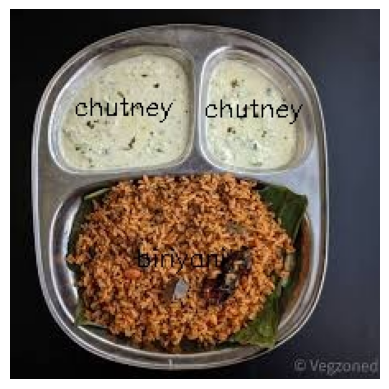

In [132]:
img_path = 'puliyogare.jpg'
results = model(img_path)
save_dir = 'predictions/'
os.makedirs(save_dir, exist_ok=True)

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


annotated_image, bboxes_array, cls = draw_boxes(image, results)

output_image_path = os.path.join(save_dir, os.path.basename(img_path))
cv2.imwrite(output_image_path, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))


def display_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

display_image(output_image_path)

In [133]:
cls

['chutney', 'chutney', 'biriyani']

In [134]:
def class_cnt(cls):
    class_cnt_dict={}
    for item in cls:
        if item not in class_cnt_dict:
            class_cnt_dict[item] = 1
        else:
            class_cnt_dict[item]+=1
    return class_cnt_dict

In [135]:
c = class_cnt(cls)


In [136]:
bboxes_array

array([[ 28,  23, 110,  99],
       [118,  26, 179,  98],
       [ 34,  99, 174, 208]])

In [137]:
import torch

In [138]:
class_colors={}

In [139]:
def show_mask(mask, ax, detected_class,i):
    global class_colors
    h, w = mask.shape[-2:]

    
    if detected_class[i] not in class_colors:
        
        color=np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        class_colors[detected_class[i]] = color

    else:
        color = class_colors[detected_class[i]]

   
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

  


In [140]:
# def show_mask(mask, ax, random_color=False):
#     if random_color:
#         color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
#     else:
#         color = np.array([30/255, 144/255, 255/255, 0.6])
#     h, w = mask.shape[-2:]
#     mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
#     ax.imshow(mask_image)
    
# def show_points(coords, labels, ax, marker_size=375):
#     pos_points = coords[labels==1]
#     neg_points = coords[labels==0]
#     ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
#     ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
# def show_box(box, ax):
#     x0, y0 = box[0], box[1]
#     w, h = box[2] - box[0], box[3] - box[1]
#     ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [141]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "default"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [142]:
predictor.set_image(annotated_image)

In [143]:
input_boxes = torch.tensor(bboxes_array, device=predictor.device)

In [144]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [145]:
masks.shape

torch.Size([3, 1, 225, 225])

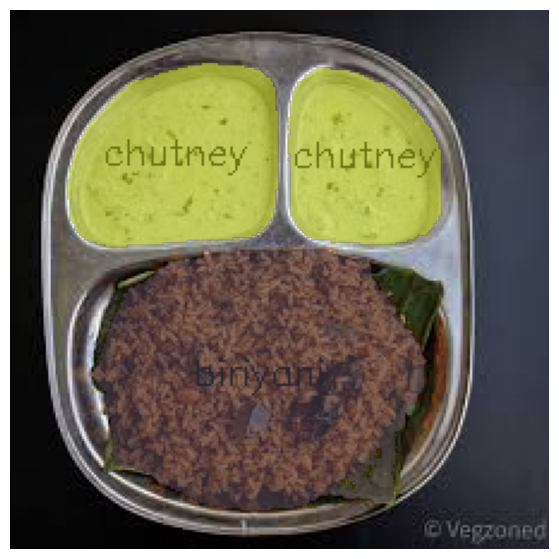

In [146]:
plt.figure(figsize=(10, 7))
plt.imshow(image)
i=0
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), cls,i)
    i=i+1
    
# for box in input_boxes:
    # show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

In [16]:
cv2.imshow("window", image)
cv2.destroyAllWindows()

In [17]:
class_colors

{'idly': array([    0.96979,    0.074716,     0.40468,         0.6]),
 'vada': array([    0.38373,     0.21887,     0.96214,         0.6]),
 'sambar': array([    0.23338,     0.79649,     0.31123,         0.6]),
 'chutney': array([    0.40765,     0.22404,     0.89135,         0.6])}

In [18]:
!python --version

Python 3.9.19


In [52]:
import numpy as np

def calculate_iou_numpy(box1, box2):
    """
    Calculate the Intersection over Union (IoU) between each pair of boxes in box1 and box2 using numpy.

    Parameters:
    - box1: np.ndarray of shape (N, 4) where each row represents [x_min, y_min, x_max, y_max]
    - box2: np.ndarray of shape (M, 4) where each row represents [x_min, y_min, x_max, y_max]

    Returns:
    - IoU matrix of shape (N, M), where the value at (i, j) is the IoU of box1[i] with box2[j]
    """
    # Coordinates of intersection rectangle
    x_min_inter = np.maximum(box1[:, None, 0], box2[:, 0])
    y_min_inter = np.maximum(box1[:, None, 1], box2[:, 1])
    x_max_inter = np.minimum(box1[:, None, 2], box2[:, 2])
    y_max_inter = np.minimum(box1[:, None, 3], box2[:, 3])

    # Calculate intersection area
    inter_width = np.maximum(0, x_max_inter - x_min_inter)
    inter_height = np.maximum(0, y_max_inter - y_min_inter)
    intersection_area = inter_width * inter_height

    # Calculate areas of each box
    box1_area = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    box2_area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

    # Calculate IoU
    union_area = box1_area[:, None] + box2_area - intersection_area
    iou = intersection_area / np.maximum(union_area, 1e-10)  # Avoid division by zero
    return iou

def get_bboxes_with_max_iou_numpy(input_bboxes, candidate_bboxes):
    """
    Get the bounding boxes with the maximum IoU for each input bounding box.

    Parameters:
    - input_bboxes: np.ndarray of shape (N, 4) for input bounding boxes, each row [x_min, y_min, x_max, y_max].
    - candidate_bboxes: np.ndarray of shape (M, 4), where each row is a bounding box [x_min, y_min, x_max, y_max].

    Returns:
    - Array of bounding boxes with maximum IoU for each input bounding box, of shape (N, 4).
    """
    # Calculate IoU matrix
    ious = calculate_iou_numpy(input_bboxes, candidate_bboxes)
    
    # Find the index of the candidate bbox with the maximum IoU for each input bbox
    max_iou_indices = np.argmax(ious, axis=1)
    
    # Select the candidate bboxes with the maximum IoU
    max_iou_bboxes = candidate_bboxes[max_iou_indices]
    
    return max_iou_bboxes

# Example usage
input_bboxes = np.array([
    [10, 10, 50, 50],
    [20, 20, 40, 40]
])

candidate_bboxes = np.array([
    [15, 15, 45, 45],
    [30, 30, 60, 60],
    [50, 50, 90, 90]
])

max_iou_bboxes = get_bboxes_with_max_iou_numpy(input_bboxes, candidate_bboxes)
print("Bounding boxes with max IoU for each input bbox:", max_iou_bboxes)


Bounding boxes with max IoU for each input bbox: [[15 15 45 45]
 [15 15 45 45]]


In [53]:
import numpy as np

def calculate_iou_numpy(box1, box2):
    """
    Calculate the Intersection over Union (IoU) between each pair of boxes in box1 and box2 using numpy.

    Parameters:
    - box1: np.ndarray of shape (N, 4) where each row represents [x_min, y_min, x_max, y_max]
    - box2: np.ndarray of shape (M, 4) where each row represents [x_min, y_min, x_max, y_max]

    Returns:
    - IoU matrix of shape (N, M), where the value at (i, j) is the IoU of box1[i] with box2[j]
    """
    # Coordinates of intersection rectangle
    x_min_inter = np.maximum(box1[:, None, 0], box2[:, 0])
    y_min_inter = np.maximum(box1[:, None, 1], box2[:, 1])
    x_max_inter = np.minimum(box1[:, None, 2], box2[:, 2])
    y_max_inter = np.minimum(box1[:, None, 3], box2[:, 3])

    # Calculate intersection area
    inter_width = np.maximum(0, x_max_inter - x_min_inter)
    inter_height = np.maximum(0, y_max_inter - y_min_inter)
    intersection_area = inter_width * inter_height

    # Calculate areas of each box
    box1_area = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    box2_area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

    # Calculate IoU
    union_area = box1_area[:, None] + box2_area - intersection_area
    iou = intersection_area / np.maximum(union_area, 1e-10)  # Avoid division by zero
    return iou

def get_indices_of_max_iou_numpy(input_bboxes, candidate_bboxes):
    """
    Get the indices of the bounding boxes with the maximum IoU for each input bounding box.

    Parameters:
    - input_bboxes: np.ndarray of shape (N, 4) for input bounding boxes, each row [x_min, y_min, x_max, y_max].
    - candidate_bboxes: np.ndarray of shape (M, 4), where each row is a bounding box [x_min, y_min, x_max, y_max].

    Returns:
    - Array of indices of candidate bounding boxes with the maximum IoU for each input bounding box, of shape (N,).
    """
    # Calculate IoU matrix
    ious = calculate_iou_numpy(input_bboxes, candidate_bboxes)
    
    # Find the index of the candidate bbox with the maximum IoU for each input bbox
    max_iou_indices = np.argmax(ious, axis=1)
    
    return max_iou_indices

# Example usage
input_bboxes = np.array([
    [10, 10, 50, 50],
    [20, 20, 40, 40]
])

candidate_bboxes = np.array([
    [15, 15, 45, 45],
    [30, 30, 60, 60],
    [50, 50, 90, 90]
])

max_iou_indices = get_indices_of_max_iou_numpy(input_bboxes, candidate_bboxes)
print("Indices of bounding boxes with max IoU for each input bbox:", max_iou_indices)


Indices of bounding boxes with max IoU for each input bbox: [0 0]
